In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [15]:
# read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

#2. Clean the data

# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

retail_df.head()

# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

#3. Prepare the data for modelling
#R (Recency): Number of days since last purchase
#F (Frequency): Number of tracsactions
#M (Monetary): Total amount of transactions (revenue contributed)

# monetary
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [16]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

# merge the two dfs



,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [17]:
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
retail_df.head()

# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

retail_df.head()

# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()


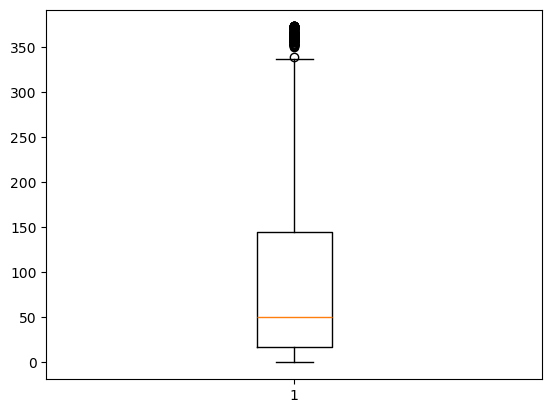

In [8]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

# two types of outliers:
# - statistical
# - domain specific

# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



<Axes: xlabel='cluster_id', ylabel='amount'>

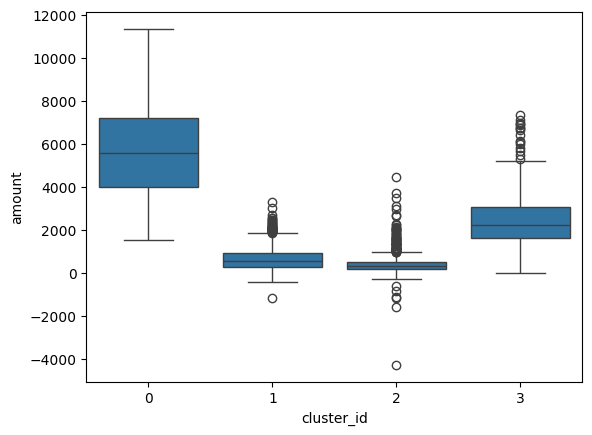

In [9]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

#4. Modelling
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

kmeans.labels_

# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)
